In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df = pd.read_csv('volk_polo_used_dataset.csv', index_col=0)

In [4]:
df_with_topics = pd.read_csv('volk_polo_description_topics.csv', index_col=0)
df_with_topics = df_with_topics.rename(columns={'0': 'desc_topic_0', 
                                                '1': 'desc_topic_1', '2':
                                                'desc_topic_2'}).drop(columns=['price'])
new_index = list(set(df_with_topics.index) & set(df.index))
df = df.loc[new_index]
df[['desc_topic_0', 'desc_topic_1', 'desc_topic_2']] = df_with_topics.loc[new_index]

In [5]:
df.head()

,city,model,photos,vin,владельцы,год выпуска,двигатель,коробка,кузов,налог,...,дтп ненайдены,почти как новый,гарантия,на гарантии,продаёт собственник,медленно теряет вцене,кузов №,desc_topic_0,desc_topic_1,desc_topic_2
0,архангельск,volkswagen polo v,1.000,xw8**************,2владельца,2012,1.6 л / 105л.с. / бензин,механическая,седан,2625₽ / год,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.733,0.265
1,санкт-петербург,volkswagen polo v рестайлинг,1.000,xw8**************,2владельца,2017,1.6 л / 90л.с. / бензин,механическая,седан,2160₽ / год,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.900,0.023,0.077
2,минеральные воды,volkswagen polo v,1.000,xw8**************,1владелец,2014,1.6 л / 105л.с. / бензин,механическая,седан,1575₽ / год,...,1.000,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.994,0.000
3,северская,volkswagen polo v рестайлинг,1.000,xw8**************,1владелец,2018,1.6 л / 110л.с. / бензин,механическая,седан,2750₽ / год,...,NaN,1.000,NaN,NaN,NaN,NaN,NaN,0.960,0.000,0.039
4,бирск,volkswagen polo v рестайлинг,1.000,xw8**************,2владельца,2019,1.6 л / 110л.с. / бензин,автоматическая,седан,3850₽ / год,...,1.000,NaN,до марта 2030,1.000,NaN,NaN,NaN,0.994,0.000,0.000


In [6]:
len(df)

2841

In [7]:
df['city'].value_counts().head(10)

москва             372
санкт-петербург    230
екатеринбург       118
краснодар           93
воронеж             67
ростов-на-дону      66
нижний новгород     55
уфа                 54
челябинск           52
самара              50
Name: city, dtype: int64

In [8]:
df['city'].value_counts().head(10).sum()

1157

In [9]:
df.columns

Index(['city', 'model', 'photos', 'vin', 'владельцы', 'год выпуска',
       'двигатель', 'коробка', 'кузов', 'налог', 'обмен', 'описание', 'привод',
       'пробег', 'птс', 'руль', 'состояние', 'таможня', 'цвет', 'цена',
       'владение', 'госномер', 'онлайн-показ', '1 владелец', 'дтп ненайдены',
       'почти как новый', 'гарантия', 'на гарантии', 'продаёт собственник',
       'медленно теряет вцене', 'кузов №', 'desc_topic_0', 'desc_topic_1',
       'desc_topic_2'],
      dtype='object')

In [10]:
df = df.rename(columns={'владельцы': 'owners', 'год выпуска': 'year_of_release',
                        'двигатель': 'engine', 'коробка': 'transmission',
                        'кузов': 'car_type', 'налог': 'tax', 'привод': 'drive_type',
                        'описание': 'description', 'пробег': 'mileage', 'птс': 'ptc',
                        'руль': 'steering_wheel', 'состояние': 'condition', 
                        'таможня': 'customhouse', 'цвет': 'color', 'цена': 'price',
                        'обмен': 'exchange', 'гарантия': 'guarantee', 'владение': 'ownership',
                        'кузов №': 'body_type_number', 'запас хода': 'capacity reserve',
                        'госномер': 'gos_num', 'кузов №': 'body_nomber', 'почти как новый': 'just_like_new',
                        'дтп ненайдены': 'no_dtp', 'онлайн-показ': 'online_show',
                        '1 владелец': 'one_owner', 'комплектация': 'equipment',
                        'продаёт собственник': 'sells_owner', 'на гарантии': 'on_guarantee',
                        'проверенный автомобиль': 'checked_auto', 'медленно теряет вцене': 'loses_price'})

In [11]:
df.columns

Index(['city', 'model', 'photos', 'vin', 'owners', 'year_of_release', 'engine',
       'transmission', 'car_type', 'tax', 'exchange', 'description',
       'drive_type', 'mileage', 'ptc', 'steering_wheel', 'condition',
       'customhouse', 'color', 'price', 'ownership', 'gos_num', 'online_show',
       'one_owner', 'no_dtp', 'just_like_new', 'guarantee', 'on_guarantee',
       'sells_owner', 'loses_price', 'body_nomber', 'desc_topic_0',
       'desc_topic_1', 'desc_topic_2'],
      dtype='object')

### Take nlp part

In [12]:
nlp_part = df['description']
df = df.drop(columns=['description'])

### Mileage

In [13]:
df['mileage'] = df['mileage'].apply(lambda x: str(x).replace('км', '')).astype('int')

### Engine

In [14]:
def split_engine_be_features(engine_str):
    engine_split = engine_str.split('/')
    
    engine_volume = engine_split[0].strip().split(' ')[0]
    engine_power = engine_split[1].strip().split(' ')[0]
    engine_type = engine_split[2].strip()
    
    return engine_volume, engine_power, engine_type

In [15]:
df['engine_volume'], df['engine_power'], df['engine_type'] = zip(*df['engine'].map(split_engine_be_features))

df['engine_volume'] = df['engine_volume'].astype('float')

df['engine_power'] = df['engine_power'].apply(lambda x: str(x).replace('л.с.', '')).astype('int')
df['engine_power'] = df['engine_power'].astype('int')

### Tax

In [16]:
df = df[~df['tax'].isna()]

In [17]:
df.loc[~df['tax'].isna(), 'tax'] = df['tax'].apply(lambda x: str(x).replace('₽ / год', '')).astype('int')

### Online_show

In [18]:
df.loc[~df['online_show'].isna(), 'online_show'] = True
df.loc[df['online_show'].isna(), 'online_show'] = False

### Car_type

In [19]:
df['car_type'].value_counts()

седан              2550
хэтчбек 5 дв.       186
лифтбек              51
хэтчбек 3 дв.        45
универсал 5 дв.       6
Name: car_type, dtype: int64

In [20]:
df = df.loc[df['car_type'] == 'седан']

### Color

In [21]:
df['color'].value_counts()

белый          1096
серебристый     376
чёрный          340
серый           223
синий           202
коричневый      118
бежевый          84
красный          61
жёлтый           26
зелёный          10
пурпурный         5
золотистый        5
оранжевый         2
фиолетовый        1
голубой           1
Name: color, dtype: int64

In [22]:
df['color'].value_counts(normalize=True) < 0.01

белый          False
серебристый    False
чёрный         False
серый          False
синий          False
коричневый     False
бежевый        False
красный        False
жёлтый         False
зелёный         True
пурпурный       True
золотистый      True
оранжевый       True
фиолетовый      True
голубой         True
Name: color, dtype: bool

### Owners

In [23]:
df['owners'].value_counts()

1владелец      1257
2владельца      704
3 или более     589
Name: owners, dtype: int64

In [24]:
df.loc[(df['one_owner'] == 1.0) | (df['owners'] == '1владелец'), 'owners'] = '1'
df.loc[df['owners'] == '2владельца', 'owners'] = '2'
df.loc[df['owners'] == '3 или более', 'owners'] = '3+'

### Year_of_release

In [25]:
df['year_of_release'].value_counts().head(10)

2016    424
2018    335
2017    325
2013    270
2019    235
2015    230
2012    220
2011    193
2014    193
2020     48
Name: year_of_release, dtype: int64

In [26]:
df['year_of_release'] = df['year_of_release'].astype('int')

In [27]:
df = df.loc[df['year_of_release'].isin(df['year_of_release'].value_counts().head(10).index)]

### No_dtp

In [28]:
df['no_dtp'].value_counts(dropna=False)

NaN      1366
1.000    1107
Name: no_dtp, dtype: int64

In [29]:
df.loc[~df['no_dtp'].isna(), 'no_dtp'] = 'true'
df.loc[df['no_dtp'].isna(), 'no_dtp'] = 'unknown'

In [30]:
df['no_dtp'].value_counts()

unknown    1366
true       1107
Name: no_dtp, dtype: int64

### Exchange

In [31]:
df['exchange'].value_counts(dropna=False)

NaN                   1683
рассмотрю варианты     790
Name: exchange, dtype: int64

In [32]:
df['exchange'] = df['exchange'].apply(lambda x: True if pd.notna(x) else False)

In [33]:
df['exchange'].value_counts(dropna=False)

False    1683
True      790
Name: exchange, dtype: int64

### Ptc

In [34]:
df['ptc'].value_counts(dropna=False)

оригинал    2362
дубликат     111
Name: ptc, dtype: int64

### Sells_owner

In [35]:
df['sells_owner'].value_counts(dropna=False)

NaN      2228
1.000     245
Name: sells_owner, dtype: int64

In [36]:
df.loc[df['sells_owner'] == 1.0, 'sells_owner'] = 'true'
df.loc[df['sells_owner'].isna(), 'sells_owner'] = 'unknown'

In [37]:
df['sells_owner'].value_counts(dropna=False)

unknown    2228
true        245
Name: sells_owner, dtype: int64

### Price

In [38]:
df['price'] = df['price'].apply(lambda x: x.split(' ')[-1].replace('₽', '').strip()).astype('int')

### Model

In [39]:
df['model'].value_counts()

volkswagen polo v рестайлинг    1508
volkswagen polo v                965
Name: model, dtype: int64

In [40]:
df = df.loc[df['model'].isin(df['model'].value_counts().loc[df['model'].value_counts(normalize=True) > 0.05].index)]

### Photos

In [41]:
df['photos'].value_counts()

1.000    2207
0.000     266
Name: photos, dtype: int64

In [42]:
df.loc[df['photos'] == 1.0, 'photos'] = True
df.loc[df['photos'] == 0.0, 'photos'] = False

In [43]:
df['photos'].value_counts()

True     2207
False     266
Name: photos, dtype: int64

### City

In [44]:
df = df.loc[df['city'].isin(df['city'].value_counts().head(10).index)]

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1063 entries, 1 to 2913
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city             1063 non-null   object 
 1   model            1063 non-null   object 
 2   photos           1063 non-null   object 
 3   vin              1063 non-null   object 
 4   owners           1063 non-null   object 
 5   year_of_release  1063 non-null   int64  
 6   engine           1063 non-null   object 
 7   transmission     1063 non-null   object 
 8   car_type         1063 non-null   object 
 9   tax              1063 non-null   int64  
 10  exchange         1063 non-null   bool   
 11  drive_type       1063 non-null   object 
 12  mileage          1063 non-null   int64  
 13  ptc              1063 non-null   object 
 14  steering_wheel   1063 non-null   object 
 15  condition        1063 non-null   object 
 16  customhouse      1063 non-null   object 
 17  color         

In [46]:
df.columns

Index(['city', 'model', 'photos', 'vin', 'owners', 'year_of_release', 'engine',
       'transmission', 'car_type', 'tax', 'exchange', 'drive_type', 'mileage',
       'ptc', 'steering_wheel', 'condition', 'customhouse', 'color', 'price',
       'ownership', 'gos_num', 'online_show', 'one_owner', 'no_dtp',
       'just_like_new', 'guarantee', 'on_guarantee', 'sells_owner',
       'loses_price', 'body_nomber', 'desc_topic_0', 'desc_topic_1',
       'desc_topic_2', 'engine_volume', 'engine_power', 'engine_type'],
      dtype='object')

In [47]:
columns_to_remove = ['engine', 'drive_type', 'one_owner',
                     'vin', 'steering_wheel', 'condition',
                     'gos_num', 'ownership', 'guarantee', 
                     'on_guarantee', 'loses_price', 'engine_type',
                     'just_like_new', 'body_nomber', 'car_type',
                     'customhouse']

In [48]:
df = df.drop(columns=columns_to_remove)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1063 entries, 1 to 2913
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city             1063 non-null   object 
 1   model            1063 non-null   object 
 2   photos           1063 non-null   object 
 3   owners           1063 non-null   object 
 4   year_of_release  1063 non-null   int64  
 5   transmission     1063 non-null   object 
 6   tax              1063 non-null   int64  
 7   exchange         1063 non-null   bool   
 8   mileage          1063 non-null   int64  
 9   ptc              1063 non-null   object 
 10  color            1063 non-null   object 
 11  price            1063 non-null   int64  
 12  online_show      1063 non-null   object 
 13  no_dtp           1063 non-null   object 
 14  sells_owner      1063 non-null   object 
 15  desc_topic_0     1063 non-null   float64
 16  desc_topic_1     1063 non-null   float64
 17  desc_topic_2  

In [50]:
cols_with_incorrect_low_values = ['color', 'engine_volume', 'engine_power']
for col in cols_with_incorrect_low_values:
    values_above = df[col].value_counts().loc[df[col].value_counts(normalize=True) < 0.05].index
    df = df[~df[col].isin(values_above)]

In [51]:
df.nunique()

city                10
model                2
photos               2
owners               3
year_of_release     10
transmission         2
tax                 24
exchange             2
mileage            664
ptc                  2
color                6
price              333
online_show          2
no_dtp               2
sells_owner          2
desc_topic_0       620
desc_topic_1       447
desc_topic_2       524
engine_volume        1
engine_power         3
dtype: int64

In [52]:
len(df)

930

### Concert categorical and numeric features

In [53]:
categorical_features = ['city', 'model', 'photos', 'transmission', 'online_show', 'color', 'owners',
                        'no_dtp', 'exchange', 'ptc', 'sells_owner', 
                        'engine_volume', 'engine_power']

numeric_features = ['tax', 'year_of_release', 'mileage']

In [54]:
df = pd.get_dummies(data=df, columns=categorical_features, drop_first=True)

In [55]:
for num_feature in numeric_features:
    df[num_feature] = df[num_feature].astype('int')

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 930 entries, 1 to 2913
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   year_of_release                     930 non-null    int64  
 1   tax                                 930 non-null    int64  
 2   mileage                             930 non-null    int64  
 3   price                               930 non-null    int64  
 4   desc_topic_0                        930 non-null    float64
 5   desc_topic_1                        930 non-null    float64
 6   desc_topic_2                        930 non-null    float64
 7   city_екатеринбург                   930 non-null    uint8  
 8   city_краснодар                      930 non-null    uint8  
 9   city_москва                         930 non-null    uint8  
 10  city_нижний новгород                930 non-null    uint8  
 11  city_ростов-на-дону                 930 non-

### Drop NA

In [57]:
df = df.dropna(how='any')

### Split data

In [58]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['price']),
                                                    df['price'], 
                                                    test_size=0.25)

In [59]:
X_train.shape, X_test.shape

((697, 32), (233, 32))

### Scaling

In [60]:
scaler_x = MinMaxScaler()
X_train[numeric_features] = scaler_x.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler_x.transform(X_test[numeric_features])

In [61]:
X_train_for_nlp = X_train.copy()
X_test_for_nlp = X_test.copy()

X_train = X_train.drop(columns=['desc_topic_0', 'desc_topic_1', 'desc_topic_2'])
X_test = X_test.drop(columns=['desc_topic_0', 'desc_topic_1', 'desc_topic_2'])

## Modeling

In [62]:
y_train.median(), y_test.median()

(650000.0, 649000.0)

### BaseLine

In [63]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def dataframe_metrics(y_test,y_pred):
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats

In [64]:
measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

""
error_type
MAE
RMSE
R2
MAPE


In [65]:
median_train = y_train.median()
baseline = np.array([median_train] * len(y_test))
measured_metrics['baseline'] = dataframe_metrics(y_test, baseline)
measured_metrics

,error_type,baseline
0,MAE,134233.047
1,RMSE,165609.119
2,R2,-0.008
3,MAPE,24.042


### Linear Reg

In [66]:
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

LinearRegression()

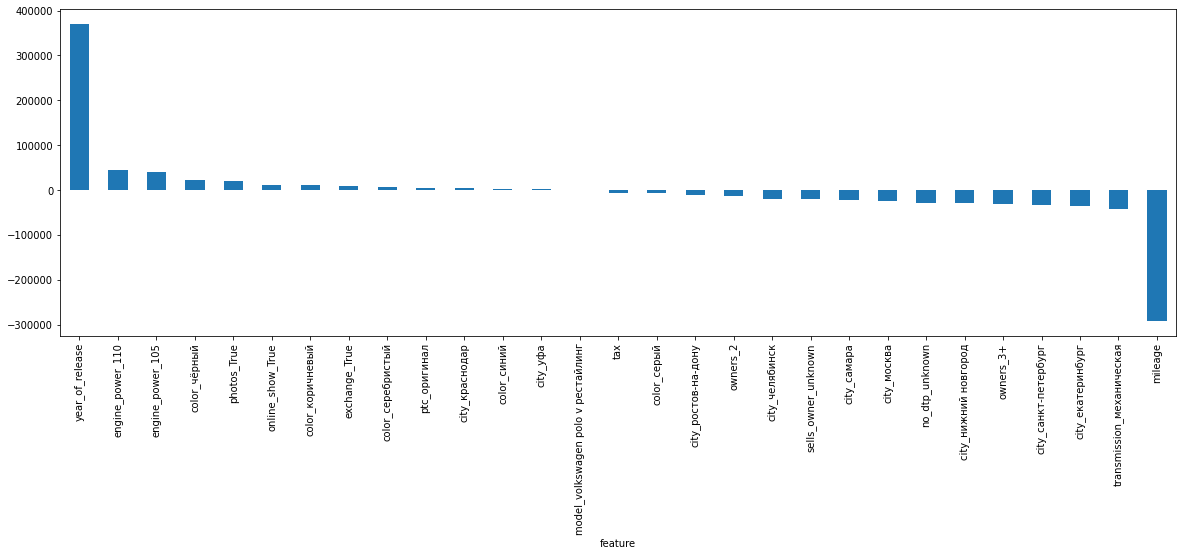

In [67]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": lin_reg.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(20, 6));

In [68]:
predictions = lin_reg.predict(X_test)

In [69]:
measured_metrics["lin_reg"] = dataframe_metrics(y_test, predictions)
measured_metrics

,error_type,baseline,lin_reg
0,MAE,134233.047,43708.645
1,RMSE,165609.119,54947.303
2,R2,-0.008,0.889
3,MAPE,24.042,7.425


In [70]:
df[['price']].describe()

,price
count,930.000
mean,643156.410
std,161594.890
min,300000.000
25%,505000.000
50%,649000.000
75%,755000.000
max,1080000.000


## RidgeCV

In [71]:
ridge_cv = RidgeCV()

ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

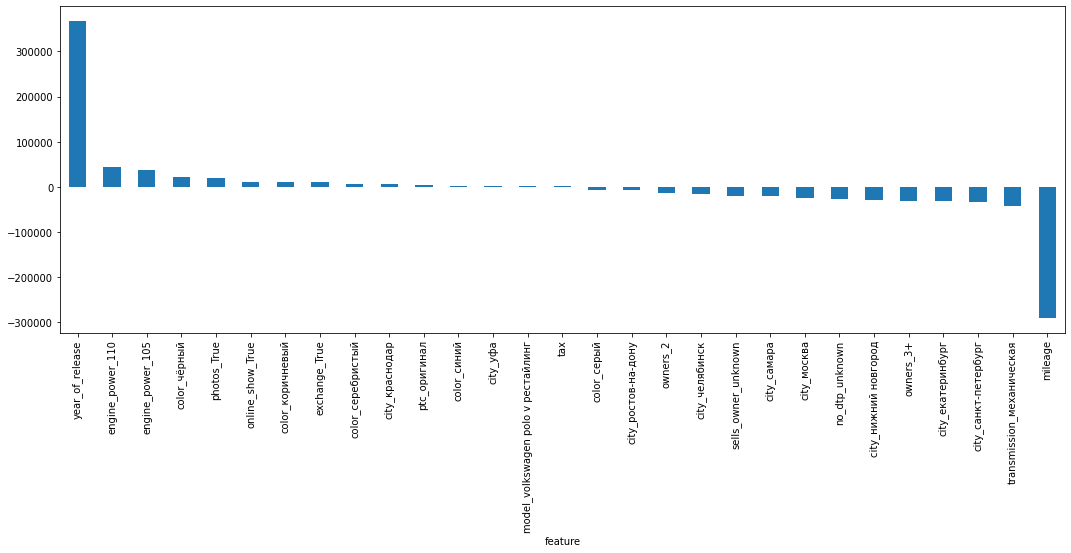

In [72]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": ridge_cv.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(18, 6));

In [73]:
predictions = ridge_cv.predict(X_test)
measured_metrics["ridge_cv"] = dataframe_metrics(y_test, predictions)
measured_metrics

,error_type,baseline,lin_reg,ridge_cv
0,MAE,134233.047,43708.645,43765.040
1,RMSE,165609.119,54947.303,54964.119
2,R2,-0.008,0.889,0.889
3,MAPE,24.042,7.425,7.430


## LassoCV

In [74]:
lasso_cv = LassoCV()

lasso_cv.fit(X_train, y_train)

LassoCV()

,error_type,baseline,lin_reg,ridge_cv,lasso_cv
0,MAE,134233.047,43708.645,43765.040,44480.324
1,RMSE,165609.119,54947.303,54964.119,55419.133
2,R2,-0.008,0.889,0.889,0.887
3,MAPE,24.042,7.425,7.430,7.531


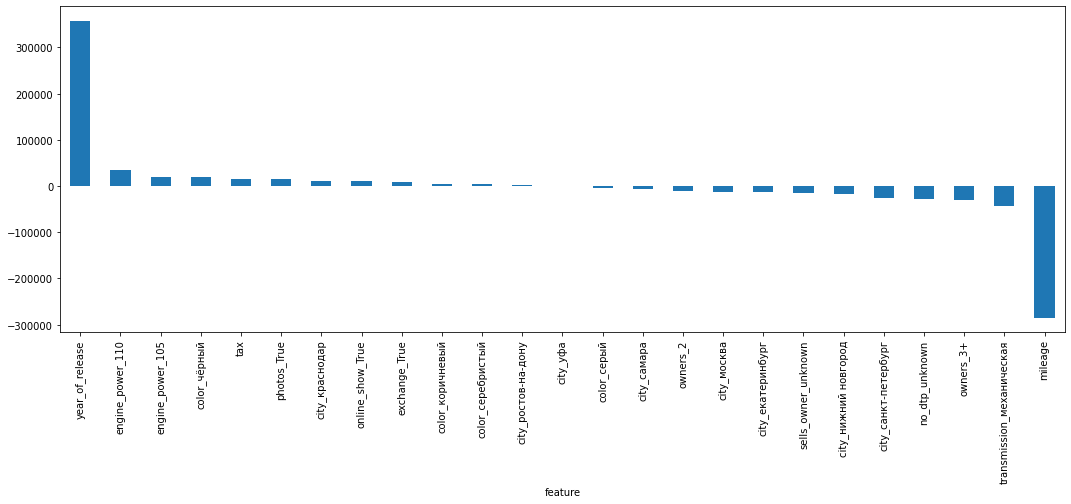

In [75]:
featureImportance = pd.DataFrame({"feature": X_train.columns[lasso_cv.coef_!=0], 
                                  "importance": lasso_cv.coef_[lasso_cv.coef_!=0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(18, 6));

measured_metrics["lasso_cv"] = dataframe_metrics(y_test, lasso_cv.predict(X_test))
measured_metrics

### Random Forest

In [76]:
rf_reg = RandomForestRegressor(n_jobs=-1)
rf_reg.fit(X_train, y_train)

measured_metrics["rf_reg"] = dataframe_metrics(y_test, rf_reg.predict(X_test))
measured_metrics

,error_type,baseline,lin_reg,ridge_cv,lasso_cv,rf_reg
0,MAE,134233.047,43708.645,43765.040,44480.324,46653.290
1,RMSE,165609.119,54947.303,54964.119,55419.133,60242.209
2,R2,-0.008,0.889,0.889,0.887,0.867
3,MAPE,24.042,7.425,7.430,7.531,7.969


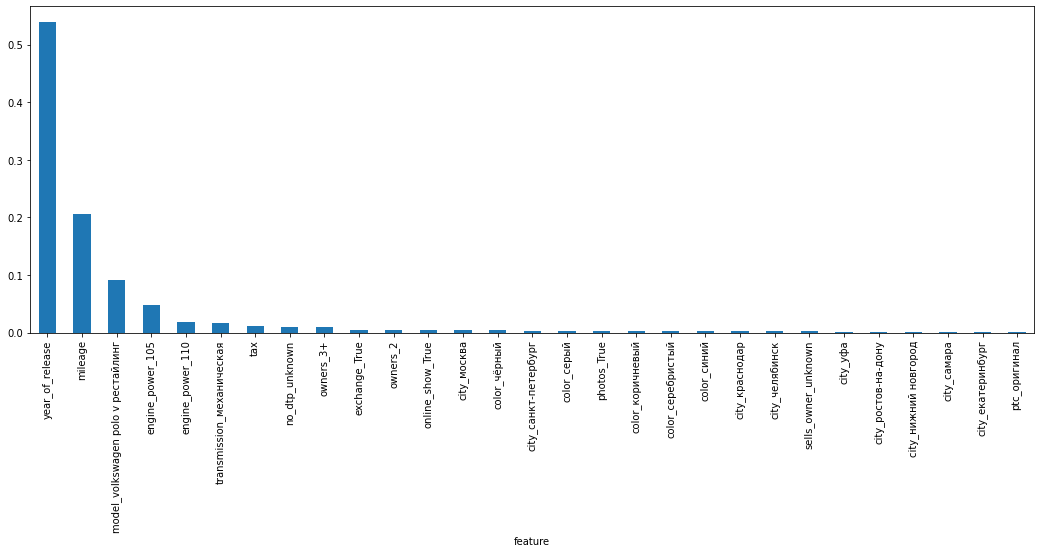

In [77]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": rf_reg.feature_importances_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(18, 6));

# TEST WITH NLP

### Linear Reg

In [78]:
lin_reg_nlp = LinearRegression()

lin_reg_nlp.fit(X_train_for_nlp, y_train)

LinearRegression()

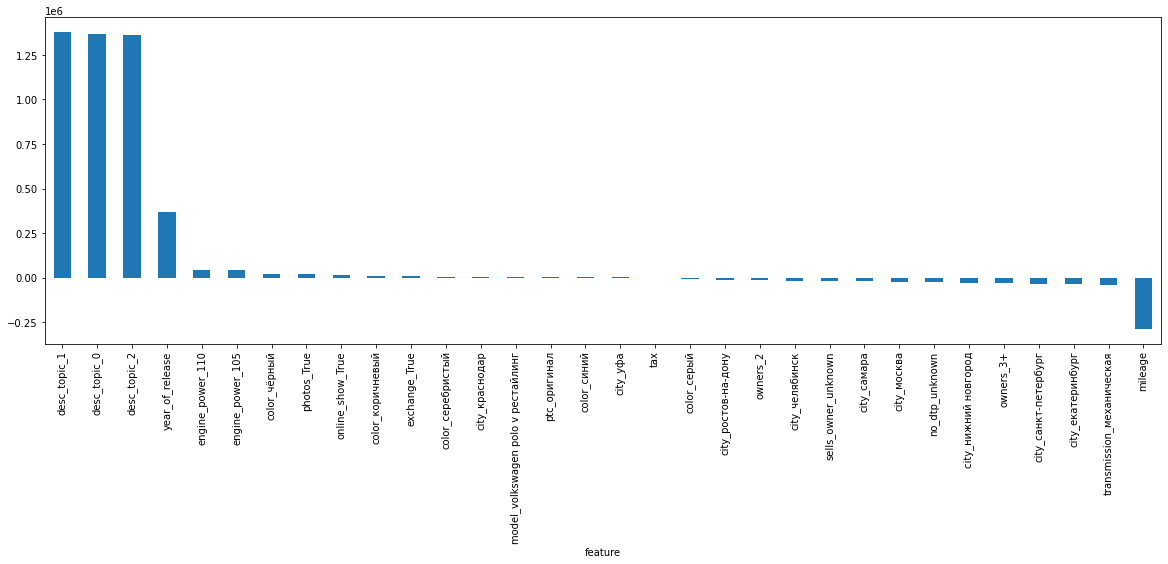

In [79]:
featureImportance = pd.DataFrame({"feature": X_train_for_nlp.columns, 
                                  "importance": lin_reg_nlp.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(20, 6));

In [80]:
predictions = lin_reg_nlp.predict(X_test_for_nlp)
measured_metrics["lin_reg_nlp"] = dataframe_metrics(y_test, predictions)
measured_metrics

,error_type,baseline,lin_reg,ridge_cv,lasso_cv,rf_reg,lin_reg_nlp
0,MAE,134233.047,43708.645,43765.040,44480.324,46653.290,44108.301
1,RMSE,165609.119,54947.303,54964.119,55419.133,60242.209,55058.993
2,R2,-0.008,0.889,0.889,0.887,0.867,0.889
3,MAPE,24.042,7.425,7.430,7.531,7.969,7.503


## RidgeCV

In [81]:
ridge_cv_nlp = RidgeCV()

ridge_cv_nlp.fit(X_train_for_nlp, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

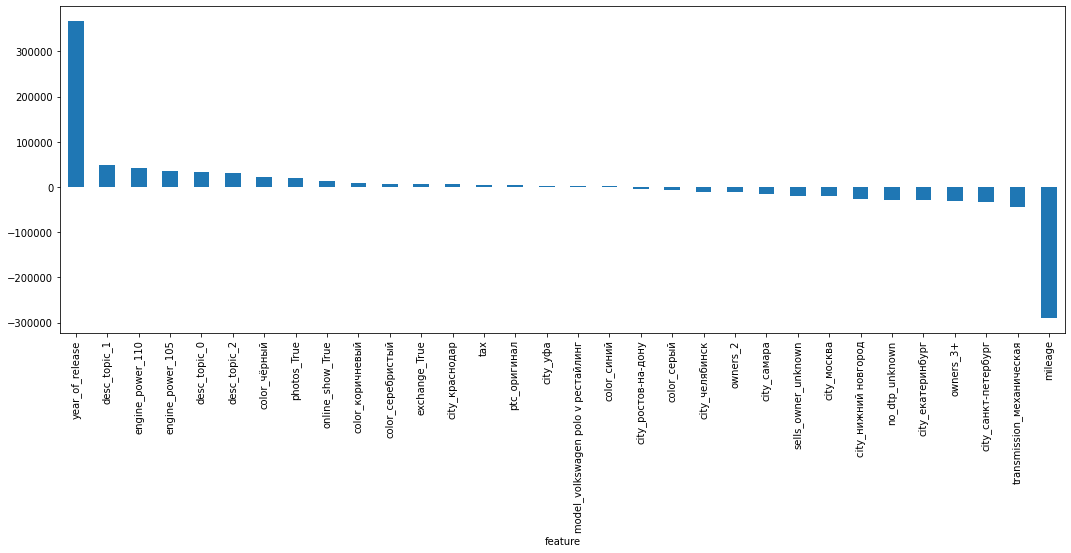

In [82]:
featureImportance = pd.DataFrame({"feature": X_train_for_nlp.columns, 
                                  "importance": ridge_cv_nlp.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(18, 6));

In [83]:
predictions = ridge_cv_nlp.predict(X_test_for_nlp)
measured_metrics["ridge_cv_nlp"] = dataframe_metrics(y_test, predictions)
measured_metrics

,error_type,baseline,lin_reg,ridge_cv,lasso_cv,rf_reg,lin_reg_nlp,ridge_cv_nlp
0,MAE,134233.047,43708.645,43765.040,44480.324,46653.290,44108.301,43928.801
1,RMSE,165609.119,54947.303,54964.119,55419.133,60242.209,55058.993,55133.611
2,R2,-0.008,0.889,0.889,0.887,0.867,0.889,0.888
3,MAPE,24.042,7.425,7.430,7.531,7.969,7.503,7.460


## LassoCV

In [84]:
lasso_cv_nlp = LassoCV()

lasso_cv_nlp.fit(X_train_for_nlp, y_train)

LassoCV()

,error_type,baseline,lin_reg,ridge_cv,lasso_cv,rf_reg,lin_reg_nlp,ridge_cv_nlp,lasso_cv_nlp
0,MAE,134233.047,43708.645,43765.040,44480.324,46653.290,44108.301,43928.801,44635.917
1,RMSE,165609.119,54947.303,54964.119,55419.133,60242.209,55058.993,55133.611,55654.522
2,R2,-0.008,0.889,0.889,0.887,0.867,0.889,0.888,0.886
3,MAPE,24.042,7.425,7.430,7.531,7.969,7.503,7.460,7.560


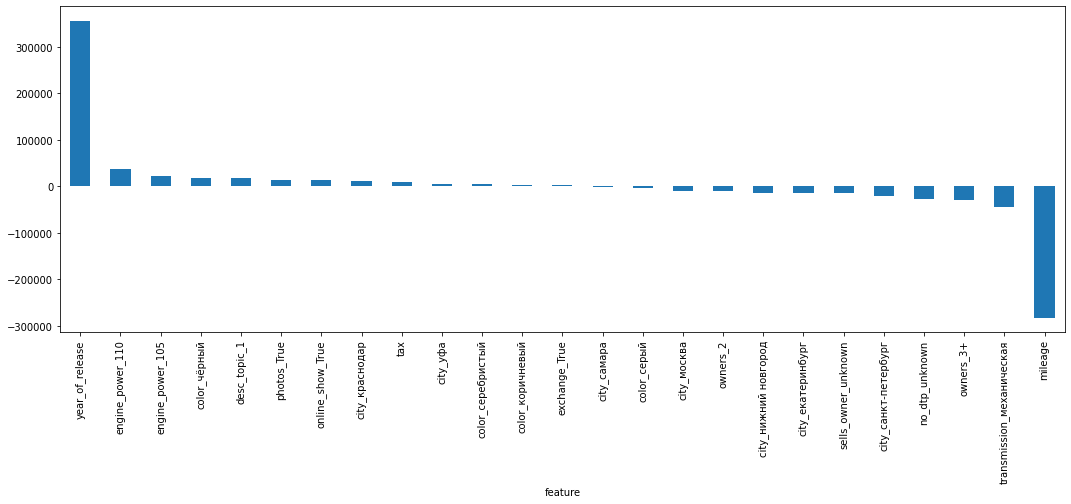

In [85]:
featureImportance = pd.DataFrame({"feature": X_train_for_nlp.columns[lasso_cv_nlp.coef_!=0], 
                                  "importance": lasso_cv_nlp.coef_[lasso_cv_nlp.coef_!=0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(18, 6));

measured_metrics["lasso_cv_nlp"] = dataframe_metrics(y_test, lasso_cv_nlp.predict(X_test_for_nlp))
measured_metrics

### Random Forest

In [86]:
rf_reg_nlp = RandomForestRegressor(n_jobs=-1)
rf_reg_nlp.fit(X_train_for_nlp, y_train)

measured_metrics["rf_reg_nlp"] = dataframe_metrics(y_test, rf_reg_nlp.predict(X_test_for_nlp))
measured_metrics

,error_type,baseline,lin_reg,ridge_cv,lasso_cv,rf_reg,lin_reg_nlp,ridge_cv_nlp,lasso_cv_nlp,rf_reg_nlp
0,MAE,134233.047,43708.645,43765.040,44480.324,46653.290,44108.301,43928.801,44635.917,44655.963
1,RMSE,165609.119,54947.303,54964.119,55419.133,60242.209,55058.993,55133.611,55654.522,58778.885
2,R2,-0.008,0.889,0.889,0.887,0.867,0.889,0.888,0.886,0.873
3,MAPE,24.042,7.425,7.430,7.531,7.969,7.503,7.460,7.560,7.651


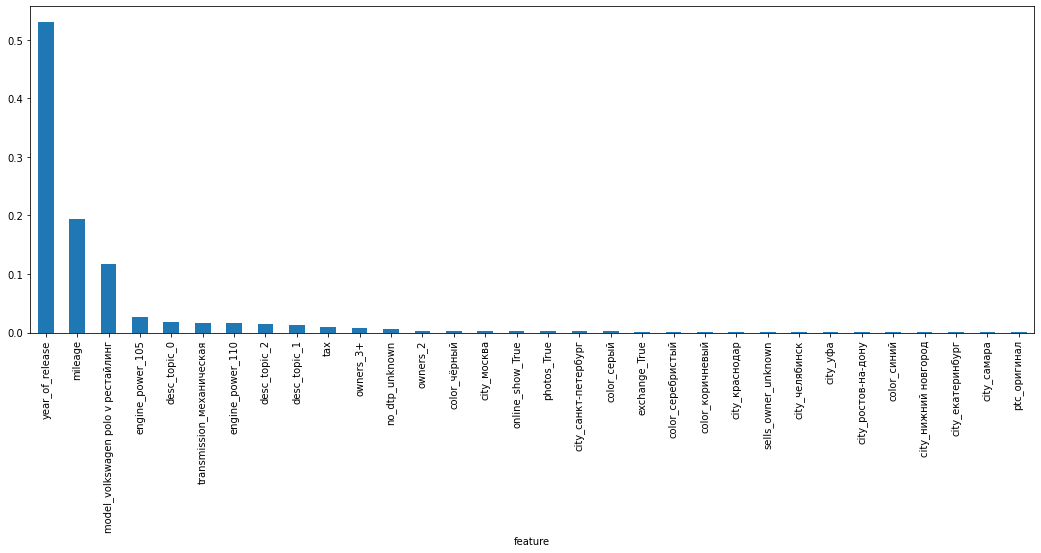

In [87]:
featureImportance = pd.DataFrame({"feature": X_train_for_nlp.columns, 
                                  "importance": rf_reg_nlp.feature_importances_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(18, 6));

In [88]:
measured_metrics

,error_type,baseline,lin_reg,ridge_cv,lasso_cv,rf_reg,lin_reg_nlp,ridge_cv_nlp,lasso_cv_nlp,rf_reg_nlp
0,MAE,134233.047,43708.645,43765.040,44480.324,46653.290,44108.301,43928.801,44635.917,44655.963
1,RMSE,165609.119,54947.303,54964.119,55419.133,60242.209,55058.993,55133.611,55654.522,58778.885
2,R2,-0.008,0.889,0.889,0.887,0.867,0.889,0.888,0.886,0.873
3,MAPE,24.042,7.425,7.430,7.531,7.969,7.503,7.460,7.560,7.651
